In [2]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from numpy import array
import pickle
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("us_insurance_costs.csv")

In [4]:
df.head() 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
df.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [7]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [8]:
cat_col = df[["children", "sex", "smoker", "region"]]

for i in cat_col.columns:
    c_num = cat_col[i].value_counts()
    print(c_num)    

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64
male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


<AxesSubplot:>

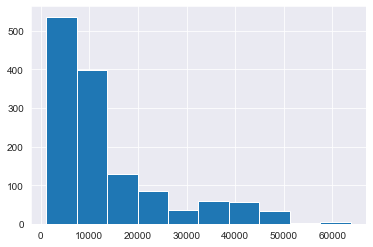

In [9]:
sns.set_style("darkgrid")
df.charges.hist()

<AxesSubplot:>

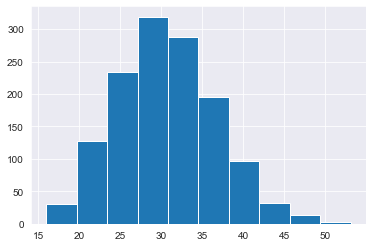

In [10]:
df.bmi.hist()

<AxesSubplot:>

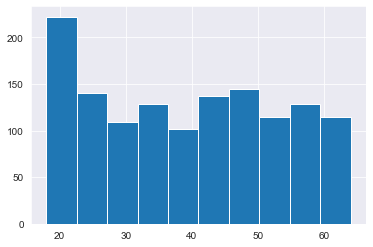

In [11]:
df.age.hist()

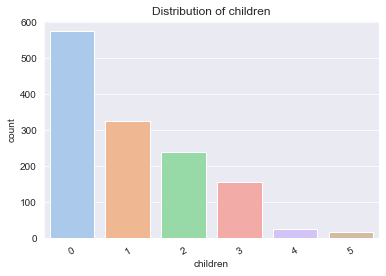

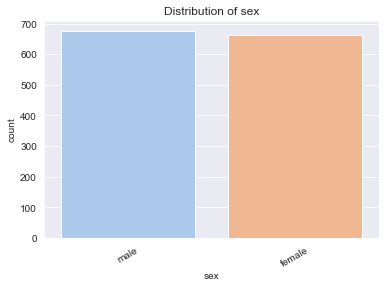

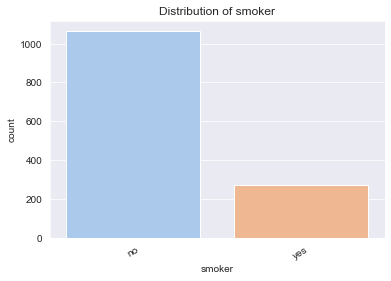

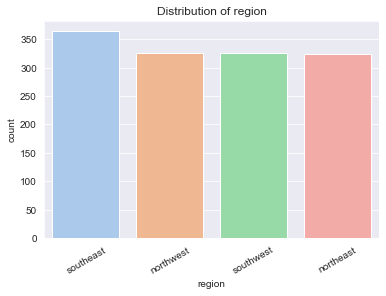

In [12]:
co = [[sns.countplot(x=df[i], order=df[i].value_counts().index, palette="pastel"),plt.title(f"Distribution of {i}"), plt.xticks(rotation=30, fontsize=10), plt.show()] for i in cat_col]

In [14]:
max_charges = df.charges.max()
min_charges = df.charges.min()
rows = df.shape[0]
print(f"The data set has {rows} records.")

columns = df.columns.values.tolist()
print (f"The data set has the following columns: {', '.join(columns)}")

total_charges = int(df["charges"].sum())
print(f"Total charges were {total_charges} $")

gender_gr = df.groupby("sex")["charges"].sum()
female_charges = int(gender_gr["female"])
male_charges = int(gender_gr["male"])
print(f"In total, female customers were charged {female_charges} $. Male customers were charged {male_charges} $")

#Percentage difference between male and female charges

def get_change(female_charges, male_charges):
    if female_charges == male_charges:
        return ("Females and males got charged equally")    
    try:
        return (abs(female_charges - male_charges) / male_charges) * 100.0
    except ZeroDivisionError:
        return 0

difference = int(get_change(female_charges, male_charges))

def change(female_charges, male_charges, difference):
    if female_charges > male_charges:
        print("Females were charged more than men: by " + str(difference) + " %")
    else:
        print("Males were charged more than women: by " + str(difference) + " %")
        
change(female_charges, male_charges, difference)


The data set has 1338 records.
The data set has the following columns: age, sex, bmi, children, smoker, region, charges
Total charges were 17755824 $
In total, female customers were charged 8321061 $. Male customers were charged 9434763 $
Males were charged more than women: by 11 %


In [18]:
# Get unique region values
regions = df["region"].unique().tolist()
summs = df.groupby("region")["charges"].sum()

southwest_charges = int(summs["southwest"])
southeast_charges = int(summs["southeast"])
northwest_charges = int(summs["northwest"])
northeast_charges = int(summs["northeast"])

region_dict = {"Southwest region": southwest_charges, "Southeast region": southeast_charges, "Northwest region": northwest_charges, "Northeast region": northeast_charges }
#Find a region with the most and the least charges

region_with_max_charges = max(region_dict, key = lambda k: region_dict[k])
region_with_min_charges = min(region_dict, key = lambda k: region_dict[k])
print(str(region_with_max_charges) + " had the most charges - " + str(max_charges) + " $" + " vs the " + str(region_with_min_charges) + " having the smallest total charges - " + str( min_charges) + " $")



Southeast region had the most charges - 63770.42801 $ vs the Southwest region having the smallest total charges - 1121.8739 $


In [19]:
#Group regions by a number of smokers

v_count = df.groupby("region")["smoker"].value_counts()
region_smoker_dict = {"Southwest region": v_count["southwest"].to_dict(), "Southeast region": v_count["southeast"].to_dict(), "Northwest smokers": v_count["northwest"].to_dict(), "Northeast region": v_count["northeast"].to_dict()}

#Find a region with the most and the least smokers 

result_max = max(region_smoker_dict, key=lambda v: region_smoker_dict[v]["yes"])
result_min = min(region_smoker_dict, key=lambda v: region_smoker_dict[v]["no"])
print(f"{result_max} had the most amount of smokers. {result_min} had the least amount of smokers." )

Southeast region had the most amount of smokers. Northeast region had the least amount of smokers.


49% of the medical insurance holders are women, 51% - men.


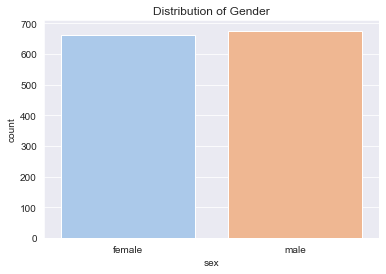

In [20]:
#Gender distribution 
sns.countplot(x="sex", data=df, palette="pastel");
plt.title("Distribution of Gender");

women_count = df["sex"].value_counts()["female"]
total = len(df.index)
women_percentage = int((women_count * 100)/total)
men_percentage = 100 - women_percentage
print(str(women_percentage) + "% of the medical insurance holders are women, " + str(men_percentage) + "% - men." )
    
    

In [21]:
#Smoker distribution

total = len(df.index)

def percentage(part, whole):
    return int(100 * float(part)/float(whole))

smoker_count = df["smoker"].value_counts()
smoker_value = smoker_count["yes"]
non_smoker_value = smoker_count["no"]

x = percentage(smoker_value, total)
y = percentage(non_smoker_value, total)

print(f"{x} % of the medical insurance holders are smokers vs {y} % being non-smokers")


20 % of the medical insurance holders are smokers vs 79 % being non-smokers


In [22]:
#Bin the BMI data into buckets

bins = [18, 25, 30, 40, 50]
labels = ["Underweight", "Normal weight", "Overweight", "Obese"]
df["bmi_group"] = pd.cut(df.bmi, bins, labels = labels, include_lowest = True)

#Bin the age data into buckets

bins = [18, 25, 35, 45, 55, 65]
labels = ["18-24", "25-34", "35-44", "45-54", "55+"]
df["age_group"] = pd.cut(df.age, bins, labels = labels, include_lowest = True)

df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_group,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,Normal weight,18-24
1,18,male,33.770,1,no,southeast,1725.55230,Overweight,18-24
2,28,male,33.000,3,no,southeast,4449.46200,Overweight,25-34
3,33,male,22.705,0,no,northwest,21984.47061,Underweight,25-34
4,32,male,28.880,0,no,northwest,3866.85520,Normal weight,25-34


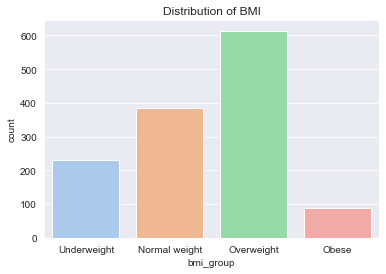

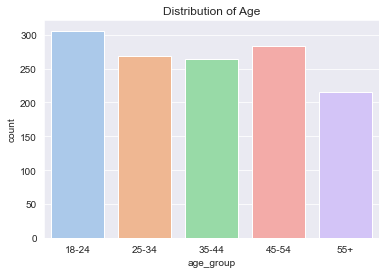

In [23]:
#BMI distribution 

sns.countplot(x="bmi_group", data=df, palette="pastel");
plt.title("Distribution of BMI");
plt.show()

plt.clf()
sns.countplot(x="age_group", data=df, palette="pastel");
plt.title("Distribution of Age");
plt.show()

In [24]:
#Group insurance holders by age group

age_count = df["age_group"].value_counts()
age_list = df["age_group"].unique().tolist()

age_group1, age_group2, age_group3, age_group4, age_group5 = ([age_count[age] for age in age_list])

#Calculate the age group percentage

def age_group_percentage(age_group):
    total = len(df.index)
    return int((age_group *100) / total)
        
age_dict = {"18-24": age_group_percentage(age_group1), "25-34": age_group_percentage(age_group2), "35-44": age_group_percentage(age_group3), "45-54":age_group_percentage(age_group4), "55+": age_group_percentage(age_group5)}

for age in age_dict:
    print(f"The {age} age group represented {age_dict[age]}% of customers")

The 18-24 age group represented 22% of customers
The 25-34 age group represented 20% of customers
The 35-44 age group represented 21% of customers
The 45-54 age group represented 19% of customers
The 55+ age group represented 16% of customers


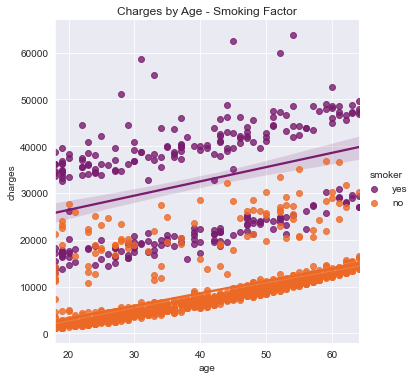

In [25]:
#Charges by age - smoking factor 

sns.lmplot(x = "age", y = "charges", data=df, hue="smoker", palette="inferno");
plt.title("Charges by Age - Smoking Factor");

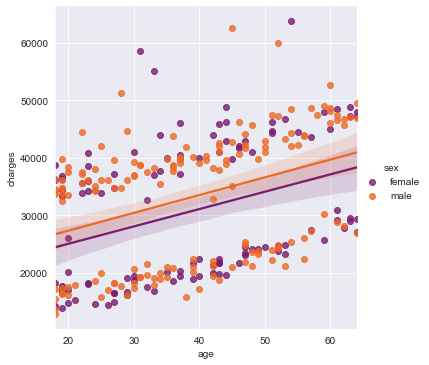

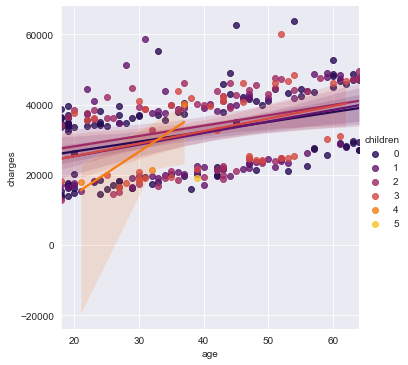

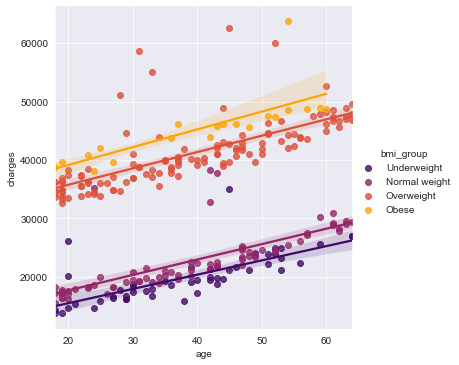

In [26]:
#Charges for smokers - females vs males

smoker_df = df.loc[df["smoker"] == "yes"]
sns.lmplot(x = "age", y = "charges", data=smoker_df,hue="sex", palette="inferno");

#Charges for smokers - children

sns.lmplot(x = "age", y = "charges", data=smoker_df,hue="children", palette="inferno");

#Charges for smokers - bmi_group

sns.lmplot(x = "age", y = "charges", data=smoker_df,hue="bmi_group", palette="inferno");


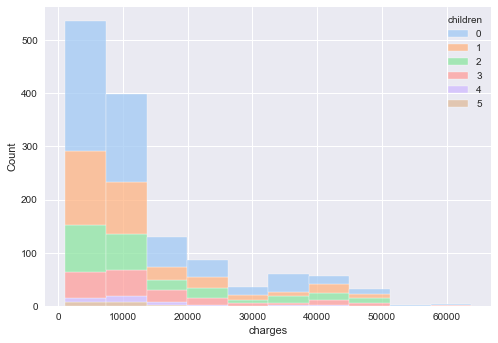

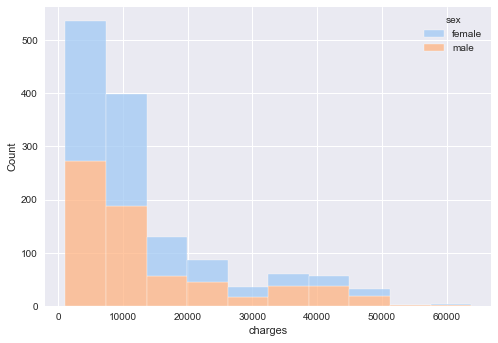

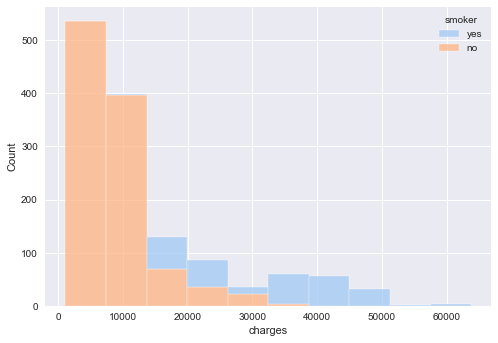

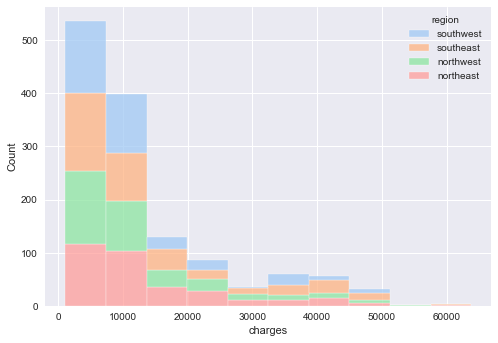

In [68]:
charges_age = [[sns.histplot(data=df, x="charges", bins = 10, hue = i, multiple="stack",palette="pastel"), plt.show()] for i in cat_col]

In [27]:
age_group_smokers = df.groupby(["age_group", "smoker"])["smoker"].count()
age_group_smokers

age_group  smoker
18-24      no        241
           yes        65
25-34      no        212
           yes        56
35-44      no        203
           yes        61
45-54      no        232
           yes        52
55+        no        176
           yes        40
Name: smoker, dtype: int64

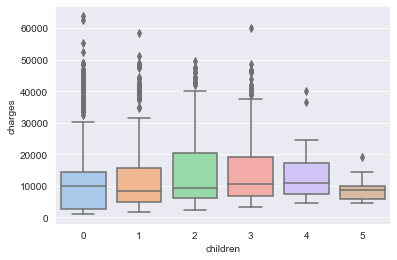

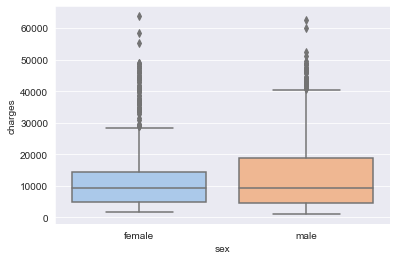

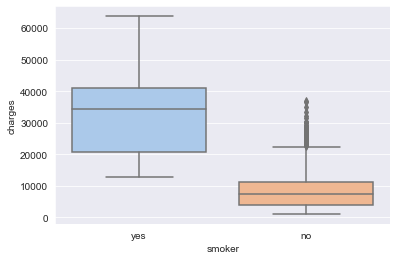

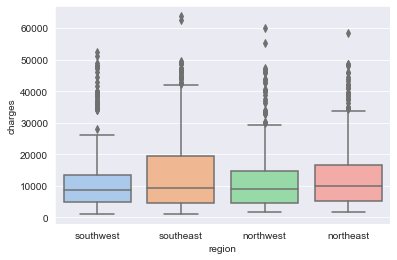

In [28]:
charges_age = [[sns.boxplot(data=df, x=i,y="charges", palette = "pastel"), plt.show()] for i in cat_col]

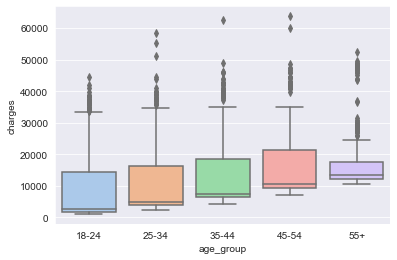

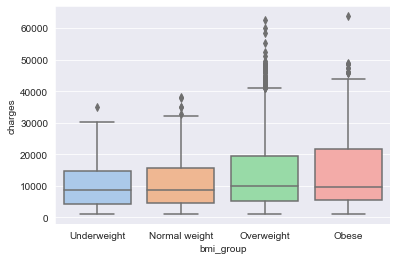

(<AxesSubplot:xlabel='bmi_group', ylabel='charges'>, None)

In [71]:
sns.boxplot(data=df, x="age_group", y="charges", palette = "pastel"), plt.show()
sns.boxplot(data=df, x="bmi_group",y="charges", palette = "pastel"), plt.show()

<AxesSubplot:xlabel='smoker', ylabel='charges'>

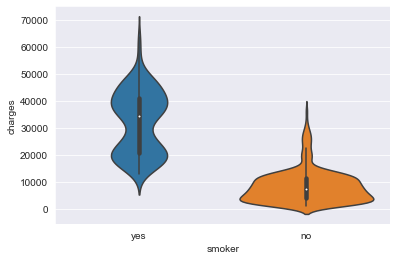

In [36]:
sns.violinplot(x="smoker", y="charges",data=df)

<AxesSubplot:xlabel='smoker', ylabel='charges'>

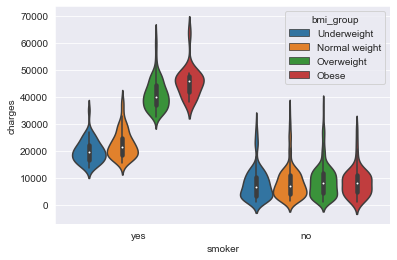

In [37]:
sns.violinplot(x="smoker", y="charges",hue="bmi_group", data=df) 

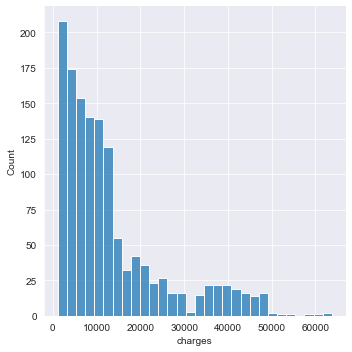

In [39]:
insurance_charges = df["charges"]
sns.displot(insurance_charges)

In [40]:
insurance_charges.skew()

1.5158796580240388

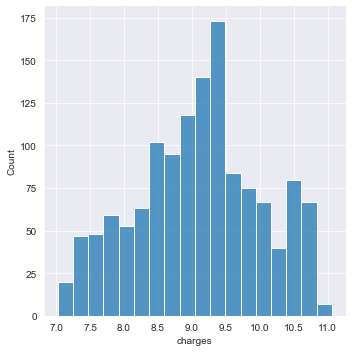

In [41]:
#Apply log transformation

log_insurance_charges = np.log(insurance_charges)
sns.displot(log_insurance_charges)

In [42]:
log_insurance_charges.skew()

-0.09009752473024583

In [43]:
#Label encode the categorical data

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
df["sex"] = le.fit_transform(df["sex"])
df["smoker"] = le.fit_transform(df["smoker"])
df["region"] =  le.fit_transform(df["region"])

In [44]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_group,age_group
0,19,0,27.900,0,1,3,16884.92400,Normal weight,18-24
1,18,1,33.770,1,0,2,1725.55230,Overweight,18-24
2,28,1,33.000,3,0,2,4449.46200,Overweight,25-34
3,33,1,22.705,0,0,1,21984.47061,Underweight,25-34
4,32,1,28.880,0,0,1,3866.85520,Normal weight,25-34


In [45]:
#Feature engineerging
x = df[["age","bmi", "smoker", "children", "region"]]
y = df["charges"]

best_features=SelectKBest(score_func =f_regression, k=3)
fit = best_features.fit(x,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x.columns)

feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']
feature_scores.nlargest(5,'Score')

,Feature_Name,Score
2,smoker,2177.614868
0,age,131.174013
1,bmi,54.709308
3,children,6.206037
4,region,0.051494


In [46]:
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


<AxesSubplot:>

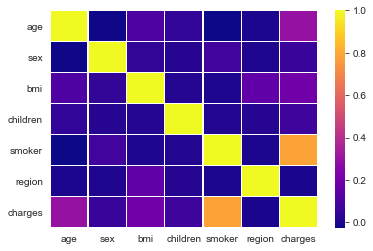

In [47]:
sns.heatmap(df.corr(), cmap ="plasma",  linewidths=.5)

In [48]:
from lazypredict.Supervised import LazyRegressor
import numpy as np

x = df[["age","bmi", "smoker"]]

## Target variable
y = log_insurance_charges

offset = int(x.shape[0] * 0.9)

x_train, y_train = x[:offset], y[:offset]
x_test, y_test = x[offset:], y[offset:]

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

C:\Users\Lika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.06it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.81       0.81  0.42        0.14
HistGradientBoostingRegressor                0.81       0.81  0.42        1.11
GradientBoostingRegressor                    0.80       0.81  0.42        0.16
NuSVR                                        0.79       0.80  0.43        0.10
SVR                                          0.79       0.80  0.43        0.06
KNeighborsRegressor                          0.79       0.79  0.44        0.03
AdaBoostRegressor                            0.75       0.76  0.47        0.06
LassoCV                                      0.75       0.76  0.48        0.08
ElasticNetCV                                 0.75       0.76  0.48        0.12
LinearRegression                             0.75       0.76  0.48        0.01
LassoLarsCV                                  0.75   

In [50]:
x = df[["age","bmi", "smoker"]]
y = df["charges"]

# Splitting dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 2)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

# Fitting the regression model
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)
mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


The mean squared error (MSE) on test set: 23371697.5365


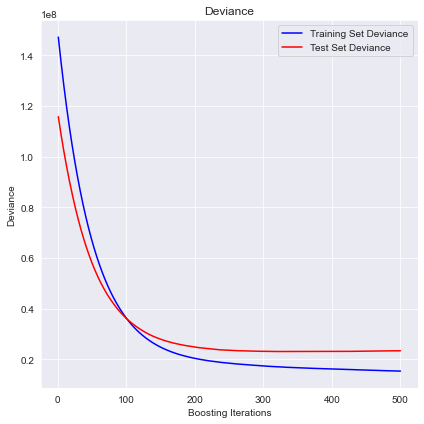

In [51]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()


In [52]:
y_train_predict = reg.predict(x_train)
y_test_predict = reg.predict(x_test)

#Comparing actual output values with the predicted values 

new_df_compare = pd.DataFrame({"Actual": y_train, "Predicted": y_train_predict})
new_df_compare

,Actual,Predicted
7,7281.51,6459.70
597,5594.85,6640.04
226,2689.50,5814.86
263,36219.41,36868.43
1218,41661.60,42152.05
...,...,...
466,13224.69,14272.41
299,9249.50,10449.32
493,12574.05,13667.89
527,9861.02,10868.21


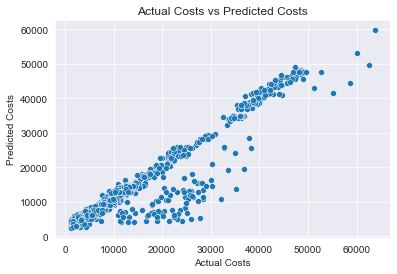

In [53]:
predictions = sns.scatterplot(x=y_train,y=y_train_predict,s = 35)
predictions.set_title("Actual Costs vs Predicted Costs")
plt.xlabel("Actual Costs")
plt.ylabel("Predicted Costs")
plt.show(predictions);


In [54]:
reg.fit(x,y)
reg.score(x, y)

0.890825595709773

In [55]:
import pickle
pickl = {"model": reg}
pickle.dump( pickl, open("model_file" + ".p", "wb" ) )

In [56]:
def load_models():
    file_name = "models/model_file.p"
    with open(file_name, "rb") as pickled:
        data = pickle.load(pickled)
        model = data["model"]
    return model